In [13]:
df1 = pd.read_csv("../data/curated/rent_growth/panel_data_updates.csv")

In [15]:
def baseline(suburb, property_type, df):
    subset = df[df["property_type"] == property_type]
    subset = subset[subset["suburb"] == suburb].reset_index(drop = True)

    if len(subset['median_rent']) < 5:
        print(f"Error for {suburb}")
        print(subset)
        return

    # auto model
    a_model = AutoReg(subset["median_rent"], lags=5).fit()
    ar_predictions = a_model.fittedvalues

    # wls model
    for lag in range(1, 6):
        subset[f'rent_lag_{lag}'] = subset['median_rent'].shift(lag)
    
    # Remove rows with NaN values (first 5 observations)
    df_clean = subset.dropna().reset_index(drop=True)
    
    # Define weights: downweight unreliable period (2021-2022)
    weights = np.ones(len(df_clean))
    unreliable_mask = (df_clean['year'] >= 2021) & (df_clean['year'] <= 2022)
    weights[unreliable_mask] = 0.1  # Downweight unreliable observations
    
    df_clean['weights'] = weights
    df_clean['is_unreliable'] = unreliable_mask
    
    
    # Prepare features and target
    feature_cols = ['rent_lag_1', 'rent_lag_2', 'rent_lag_3', 'rent_lag_4', 'rent_lag_5']
    X = df_clean[feature_cols].values
    y = df_clean['median_rent'].values
    w = df_clean['weights'].values

    # Add constant term for intercept
    X_with_const = sm.add_constant(X)

    # 2. Weighted Least Squares (WLS)
    wls_model = WLS(y, X_with_const, weights=w).fit()
    wls_predictions = wls_model.predict(X_with_const)

    # forecast the next 5 years
    ar_forecast, wls_forecast = baseline_forecast(a_model, wls_model, subset, df_clean)
    
    n_forecast = len(ar_forecast)
    subset['date'] = pd.to_datetime(subset['date'])
    df_clean['date'] = pd.to_datetime(df_clean['date'])
    last_date = subset['date'].iloc[-1]
    future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=n_forecast, freq='MS')

    # plot these 
    fig, axes = plt.subplots(2, 1, figsize=(15, 12))
        
    # Plot 1: Time series with model fits
    axes[0].plot(subset['date'], subset["median_rent"], 'b-', alpha=0.7, label='Actual', linewidth=1)
        
    # For AutoReg, we need to plot only the corresponding dates
    ar_dates = subset['date'][5:]  # Skip first 5 dates to match AutoReg
    axes[0].plot(ar_dates, ar_predictions, 'm:', alpha=0.8, label='AutoReg', linewidth=2)
    axes[0].plot(df_clean['date'], wls_predictions, 'g-', alpha=0.8, label='WLS', linewidth=2)

    axes[0].plot(future_dates, ar_forecast, 'm--', alpha=0.8, label='AR Forecast', linewidth=2)
    axes[0].plot(future_dates, wls_forecast, 'g--', alpha=0.8, label='WLS Forecast', linewidth=2)


    axes[0].set_title(f'Model Fits for {suburb} with {property_type}', fontsize=14)
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Value')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)


    # Plot 2: Residuals
    ar_residuals = subset["median_rent"][5:] - ar_predictions
    wls_residuals = df_clean["median_rent"] - wls_predictions
    
    axes[1].plot(ar_dates, ar_residuals, 'm:', alpha=0.7, label='AR Residuals')
    axes[1].plot(df_clean['date'], wls_residuals, 'g-', alpha=0.7, label='WLS Residuals')
    axes[1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
    
    axes[1].set_title(f'Model Residuals for {suburb} with {property_type}', fontsize=14)
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Residuals')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    plt.close()

    

In [17]:
def baseline_forecast(ar_model, wls_model, subset, df_clean):
    n_steps = 20
    
    # ar_forecast
    ar_forecast = ar_model.predict(
    start=len(subset),     
    end=len(subset)+n_steps-1,
    dynamic=False           
    )

    # wls forecast

    last_obs = df_clean['median_rent'].values[-5:].tolist()  # last 5 values for lags
    wls_forecast = []

    for i in range(n_steps):
        # Construct feature vector for WLS: [lag1, lag2, lag3, lag4, lag5]
        x_new = last_obs[-5:]  # last 5 known/predicted rents
        x_new_with_const = [1] + x_new  # add intercept
        # Predict next value
        next_pred = wls_model.predict(x_new_with_const)[0]
        wls_forecast.append(next_pred)
        
        # Append prediction to last_obs for next iteration
        last_obs.append(next_pred)
    

    return ar_forecast, wls_forecast


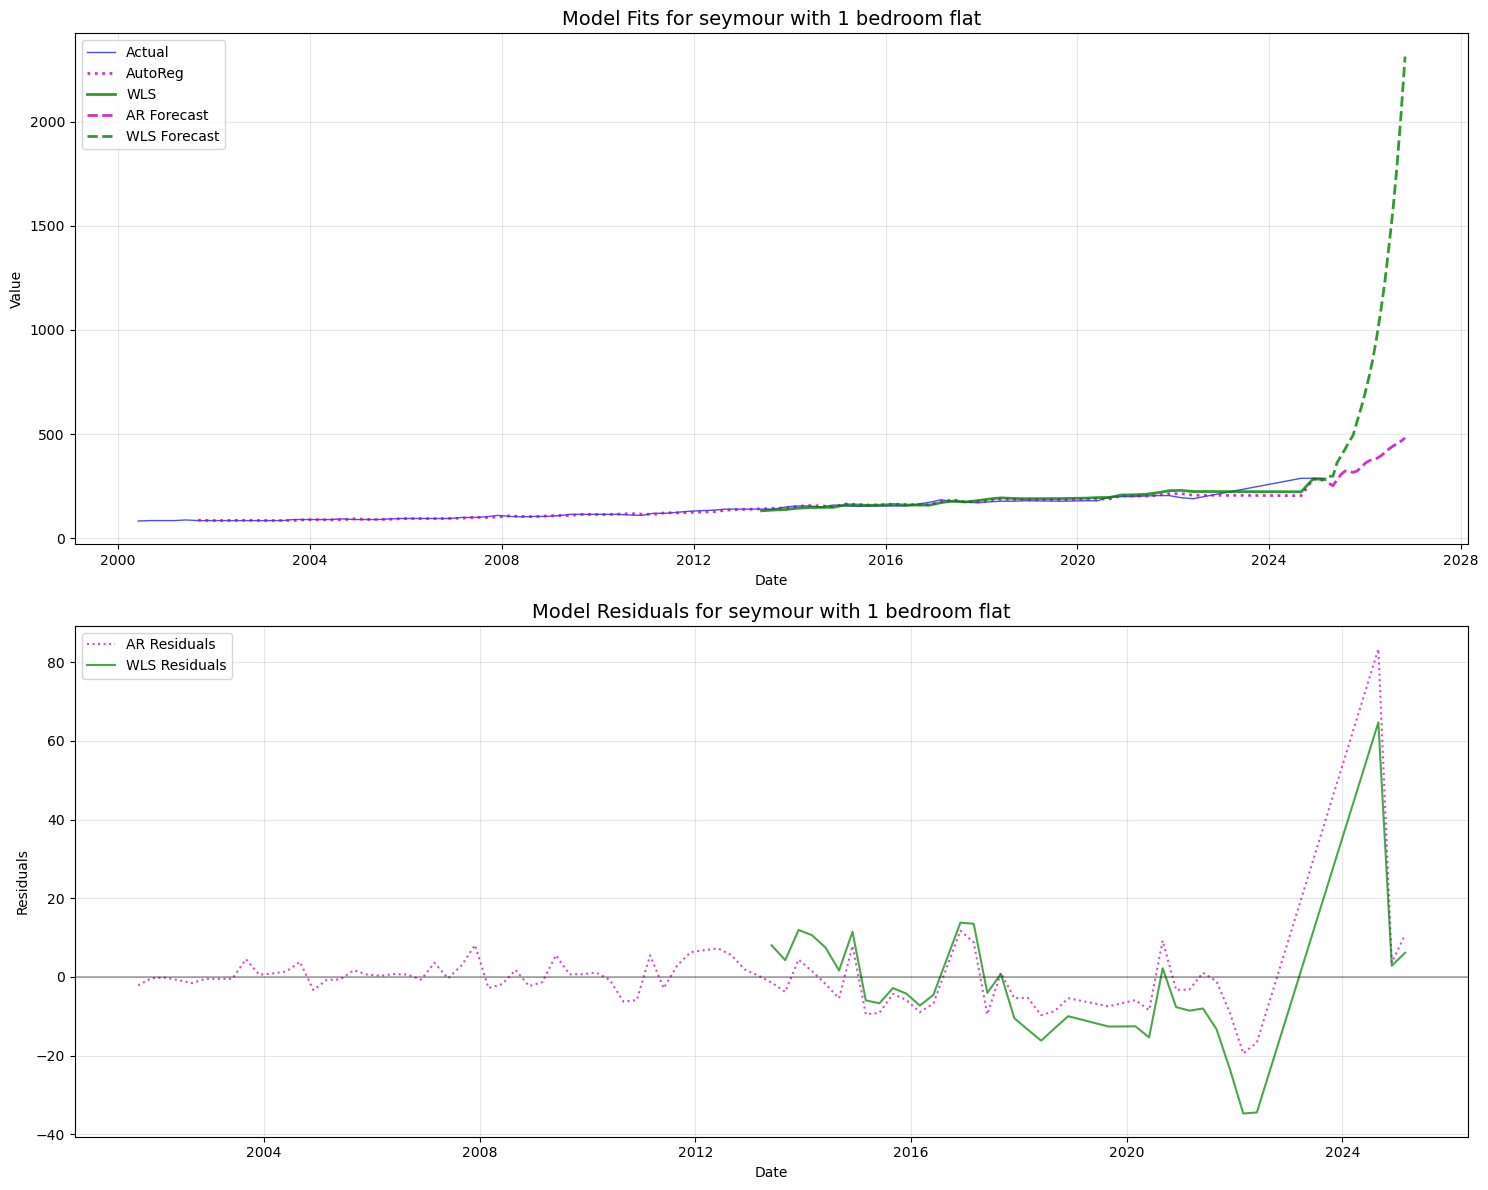

In [29]:
baseline("seymour", "1 bedroom flat", df1)

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.regression.linear_model import WLS
import statsmodels.api as sm
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Load the data
df1 = pd.read_csv("../data/curated/rent_growth/panel_data_updates.csv")

print(f"Data shape: {df1.shape}")
print(f"Unique suburbs: {df1['suburb'].nunique()}")
print(f"Unique property types: {df1['property_type'].nunique()}")
print(f"Date range: {df1['date'].min()} to {df1['date'].max()}")


Data shape: (87330, 27)
Unique suburbs: 143
Unique property types: 6
Date range: 2000-03-01 to 2025-03-01


In [2]:
def forecast_all_suburbs(df, min_observations=5, forecast_steps=20):
    """
    Forecast rent prices for all suburb-property type combinations.
    
    Parameters:
    - df: DataFrame with rent data
    - min_observations: Minimum number of observations required for forecasting
    - forecast_steps: Number of steps to forecast ahead
    
    Returns:
    - results: DataFrame with forecast results and growth calculations
    """
    
    results = []
    failed_forecasts = []
    
    # Get all unique combinations
    combinations = df.groupby(['suburb', 'property_type']).size().reset_index()
    combinations = combinations[combinations[0] >= min_observations]
    
    print(f"Processing {len(combinations)} suburb-property combinations...")
    
    for idx, row in tqdm(combinations.iterrows(), total=len(combinations)):
        suburb = row['suburb']
        property_type = row['property_type']
        
        try:
            # Get data for this combination
            subset = df[(df["property_type"] == property_type) & 
                       (df["suburb"] == suburb)].reset_index(drop=True)
            
            if len(subset) < min_observations:
                failed_forecasts.append(f"{suburb} - {property_type}: Insufficient data")
                continue
            
            # Fit AutoReg model
            ar_model = AutoReg(subset["median_rent"], lags=5).fit()
            
            # Prepare data for WLS
            for lag in range(1, 6):
                subset[f'rent_lag_{lag}'] = subset['median_rent'].shift(lag)
            
            df_clean = subset.dropna().reset_index(drop=True)
            
            if len(df_clean) < 3:  # Need at least 3 observations for WLS
                failed_forecasts.append(f"{suburb} - {property_type}: Insufficient clean data")
                continue
            
            # Define weights
            weights = np.ones(len(df_clean))
            unreliable_mask = (df_clean['year'] >= 2021) & (df_clean['year'] <= 2022)
            weights[unreliable_mask] = 0.1
            df_clean['weights'] = weights
            
            # Fit WLS model
            feature_cols = ['rent_lag_1', 'rent_lag_2', 'rent_lag_3', 'rent_lag_4', 'rent_lag_5']
            X = df_clean[feature_cols].values
            y = df_clean['median_rent'].values
            w = df_clean['weights'].values
            
            X_with_const = sm.add_constant(X)
            wls_model = WLS(y, X_with_const, weights=w).fit()
            
            # Generate forecasts
            ar_forecast = ar_model.predict(
                start=len(subset),
                end=len(subset) + forecast_steps - 1,
                dynamic=False
            )
            
            # WLS forecast
            last_obs = df_clean['median_rent'].values[-5:].tolist()
            wls_forecast = []
            
            for i in range(forecast_steps):
                x_new = last_obs[-5:]
                x_new_with_const = [1] + x_new
                next_pred = wls_model.predict(x_new_with_const)[0]
                wls_forecast.append(next_pred)
                last_obs.append(next_pred)
            
            # Calculate growth metrics
            current_rent = subset['median_rent'].iloc[-1]
            ar_final_forecast = ar_forecast.iloc[-1]
            wls_final_forecast = wls_forecast[-1]
            
            ar_growth_rate = (ar_final_forecast - current_rent) / current_rent * 100
            wls_growth_rate = (wls_final_forecast - current_rent) / current_rent * 100
            
            # Average growth rate
            avg_growth_rate = (ar_growth_rate + wls_growth_rate) / 2
            
            results.append({
                'suburb': suburb,
                'property_type': property_type,
                'current_rent': current_rent,
                'ar_forecast': ar_final_forecast,
                'wls_forecast': wls_final_forecast,
                'ar_growth_rate': ar_growth_rate,
                'wls_growth_rate': wls_growth_rate,
                'avg_growth_rate': avg_growth_rate,
                'n_observations': len(subset),
                'ar_forecast_series': ar_forecast.tolist(),
                'wls_forecast_series': wls_forecast
            })
            
        except Exception as e:
            failed_forecasts.append(f"{suburb} - {property_type}: {str(e)}")
            continue
    
    print(f"\nForecasting completed!")
    print(f"Successful forecasts: {len(results)}")
    print(f"Failed forecasts: {len(failed_forecasts)}")
    
    if failed_forecasts:
        print("\nFailed forecasts:")
        for failure in failed_forecasts[:10]:  # Show first 10 failures
            print(f"  - {failure}")
        if len(failed_forecasts) > 10:
            print(f"  ... and {len(failed_forecasts) - 10} more")
    
    return pd.DataFrame(results), failed_forecasts


In [8]:
# Run forecasts for all suburbs
print("Starting comprehensive forecasting...")
results_df, failed_forecasts = forecast_all_suburbs(df1, min_observations=5, forecast_steps=20)

# Filter out the problematic Castlemaine 1 bedroom flat that has blown up
print(f"Original results: {len(results_df)} forecasts")
results_df = results_df[~((results_df['suburb'] == 'castlemaine') & (results_df['property_type'] == '1 bedroom flat'))]
print(f"After filtering out Castlemaine 1 bedroom flat: {len(results_df)} forecasts")

# Display basic statistics
print(f"\nForecasting Results Summary:")
print(f"Total successful forecasts: {len(results_df)}")
print(f"Average growth rate: {results_df['avg_growth_rate'].mean():.2f}%")
print(f"Median growth rate: {results_df['avg_growth_rate'].median():.2f}%")
print(f"Standard deviation: {results_df['avg_growth_rate'].std():.2f}%")


Starting comprehensive forecasting...
Processing 848 suburb-property combinations...


100%|██████████| 848/848 [00:05<00:00, 167.00it/s]


Forecasting completed!
Successful forecasts: 845
Failed forecasts: 3

Failed forecasts:
  - hamilton - 3 bedroom flat: The model specification cannot be estimated. The model contains 6 regressors (1 trend, 0 seasonal, 5 lags) but after adjustment for hold_back and creation of the lags, there are only 2 data points available to estimate parameters.
  - rowville - 1 bedroom flat: division by zero
  - rowville - 2 bedroom house: shapes (1,4) and (6,) not aligned: 4 (dim 1) != 6 (dim 0)
Original results: 845 forecasts
After filtering out Castlemaine 1 bedroom flat: 844 forecasts

Forecasting Results Summary:
Total successful forecasts: 844
Average growth rate: 19.41%
Median growth rate: 16.36%
Standard deviation: 29.00%


In [13]:
# Find the largest growth suburbs
print("TOP 20 SUBURBS WITH HIGHEST GROWTH RATES:")
print("=" * 60)

top_growth = results_df.nlargest(20, 'avg_growth_rate')
for idx, row in top_growth.iterrows():
    print(f"{row['suburb']} ({row['property_type']})")
    print(f"  Current rent: ${row['current_rent']:.0f}")
    print(f"  Forecasted rent: ${row['ar_forecast']:.0f} (AR: ${row['ar_forecast']:.0f}, WLS: ${row['wls_forecast']:.0f})")
    print(f"  Growth rate: {row['ar_growth_rate']:.2f}%")
    print(f"  Observations: {row['n_observations']}")
    print("-" * 40)

# Find the single largest growth suburb
largest_growth = results_df.loc[results_df['avg_growth_rate'].idxmax()]
print(f"\n🏆 LARGEST GROWTH SUBURB:")
print(f"Suburb: {largest_growth['suburb']}")
print(f"Property Type: {largest_growth['property_type']}")
print(f"Current Rent: ${largest_growth['current_rent']:.0f}")
print(f"Forecasted Rent: ${largest_growth['ar_forecast']:.0f}")
print(f"Growth Rate: {largest_growth['ar_growth_rate']:.2f}%")
print(f"AR Growth Rate: {largest_growth['ar_growth_rate']:.2f}%")
print(f"WLS Growth Rate: {largest_growth['wls_growth_rate']:.2f}%")


TOP 20 SUBURBS WITH HIGHEST GROWTH RATES:
seymour (1 bedroom flat)
  Current rent: $288
  Forecasted rent: $482 (AR: $482, WLS: $2312)
  Growth rate: 67.26%
  Observations: 87
----------------------------------------
noble park (3 bedroom flat)
  Current rent: $570
  Forecasted rent: $729 (AR: $729, WLS: $3442)
  Growth rate: 27.96%
  Observations: 101
----------------------------------------
springvale (2 bedroom flat)
  Current rent: $500
  Forecasted rent: $573 (AR: $573, WLS: $2858)
  Growth rate: 14.51%
  Observations: 101
----------------------------------------
north melbourne-west melbourne (1 bedroom flat)
  Current rent: $503
  Forecasted rent: $524 (AR: $524, WLS: $2651)
  Growth rate: 4.16%
  Observations: 101
----------------------------------------
pascoe vale-coburg north (3 bedroom flat)
  Current rent: $600
  Forecasted rent: $683 (AR: $683, WLS: $2458)
  Growth rate: 13.80%
  Observations: 101
----------------------------------------
warragul (1 bedroom flat)
  Curren

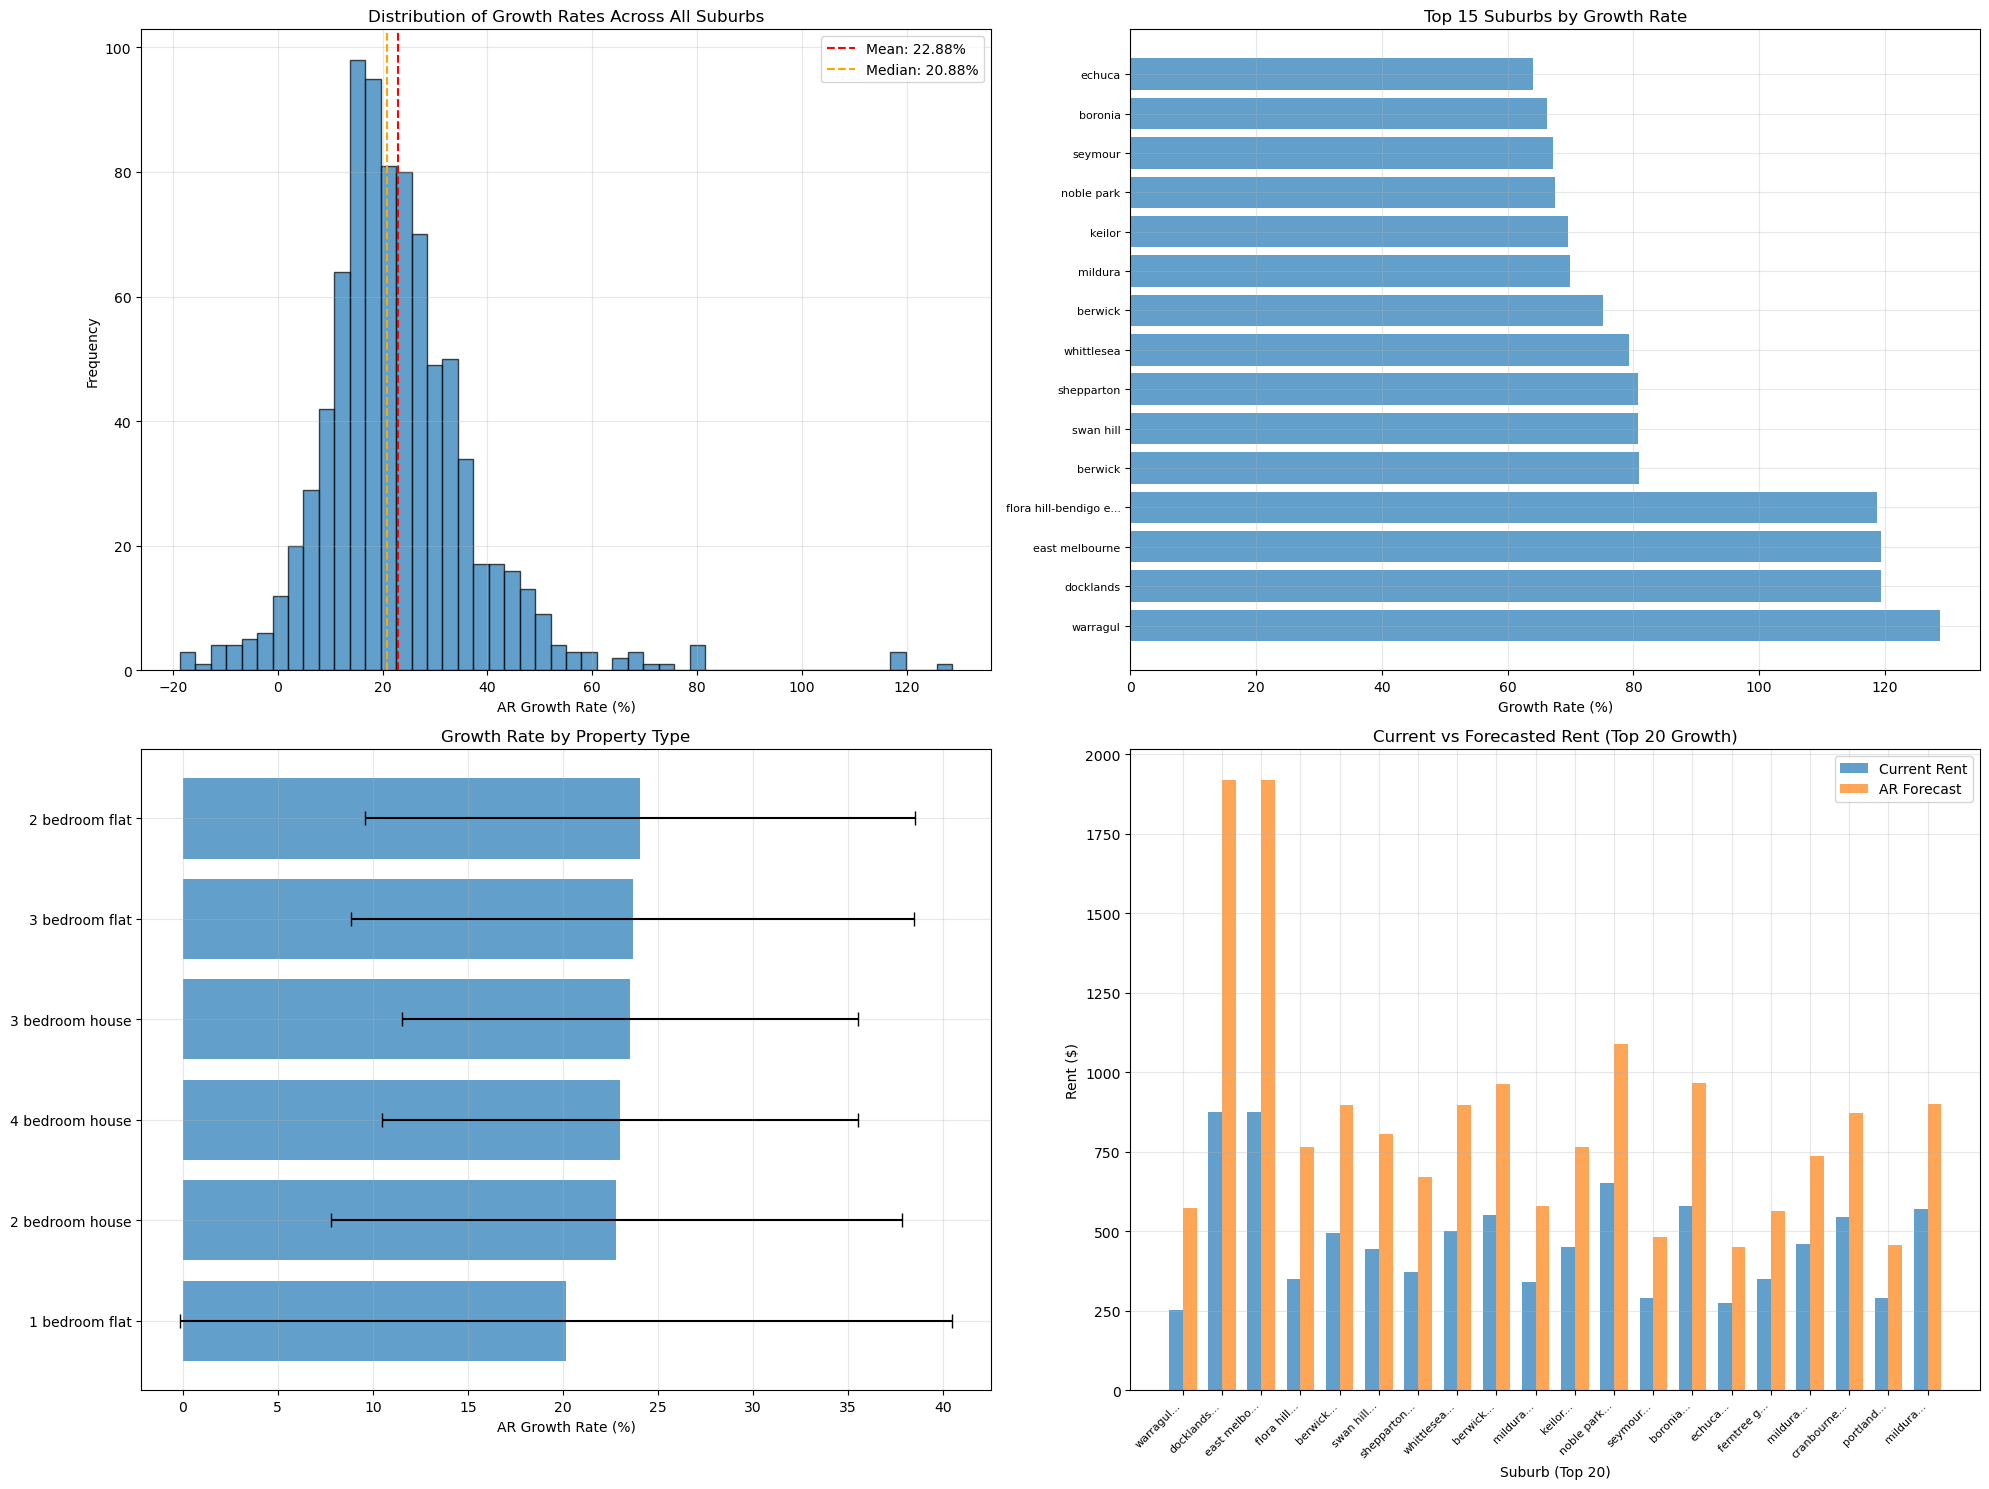

In [15]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# 1. Distribution of growth rates
axes[0, 0].hist(results_df['ar_growth_rate'], bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].axvline(results_df['ar_growth_rate'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {results_df["ar_growth_rate"].mean():.2f}%')
axes[0, 0].axvline(results_df['ar_growth_rate'].median(), color='orange', linestyle='--', 
                   label=f'Median: {results_df["ar_growth_rate"].median():.2f}%')
axes[0, 0].set_xlabel('AR Growth Rate (%)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Growth Rates Across All Suburbs')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Top 15 growth suburbs
top_15 = results_df.nlargest(15, 'ar_growth_rate')
y_pos = np.arange(len(top_15))
axes[0, 1].barh(y_pos, top_15['ar_growth_rate'], alpha=0.7)
axes[0, 1].set_yticks(y_pos)
axes[0, 1].set_yticklabels([f"{row['suburb'][:20]}..." if len(row['suburb']) > 20 
                           else row['suburb'] for _, row in top_15.iterrows()], fontsize=8)
axes[0, 1].set_xlabel('Growth Rate (%)')
axes[0, 1].set_title('Top 15 Suburbs by Growth Rate')
axes[0, 1].grid(True, alpha=0.3)

# 3. Growth rate by property type
property_growth = results_df.groupby('property_type')['ar_growth_rate'].agg(['mean', 'std', 'count']).reset_index()
property_growth = property_growth.sort_values('mean', ascending=True)
y_pos = np.arange(len(property_growth))
axes[1, 0].barh(y_pos, property_growth['mean'], alpha=0.7, 
                xerr=property_growth['std'], capsize=5)
axes[1, 0].set_yticks(y_pos)
axes[1, 0].set_yticklabels(property_growth['property_type'], fontsize=10)
axes[1, 0].set_xlabel('AR Growth Rate (%)')
axes[1, 0].set_title('Growth Rate by Property Type')
axes[1, 0].grid(True, alpha=0.3)

# 4. Current vs Forecasted rent for top 20
top_20 = results_df.nlargest(20, 'ar_growth_rate')
x = np.arange(len(top_20))
width = 0.35
axes[1, 1].bar(x - width/2, top_20['current_rent'], width, label='Current Rent', alpha=0.7)
axes[1, 1].bar(x + width/2, top_20['ar_forecast'], width, label='AR Forecast', alpha=0.7)
axes[1, 1].set_xlabel('Suburb (Top 20)')
axes[1, 1].set_ylabel('Rent ($)')
axes[1, 1].set_title('Current vs Forecasted Rent (Top 20 Growth)')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels([f"{row['suburb'][:10]}..." for _, row in top_20.iterrows()], 
                           rotation=45, ha='right', fontsize=8)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


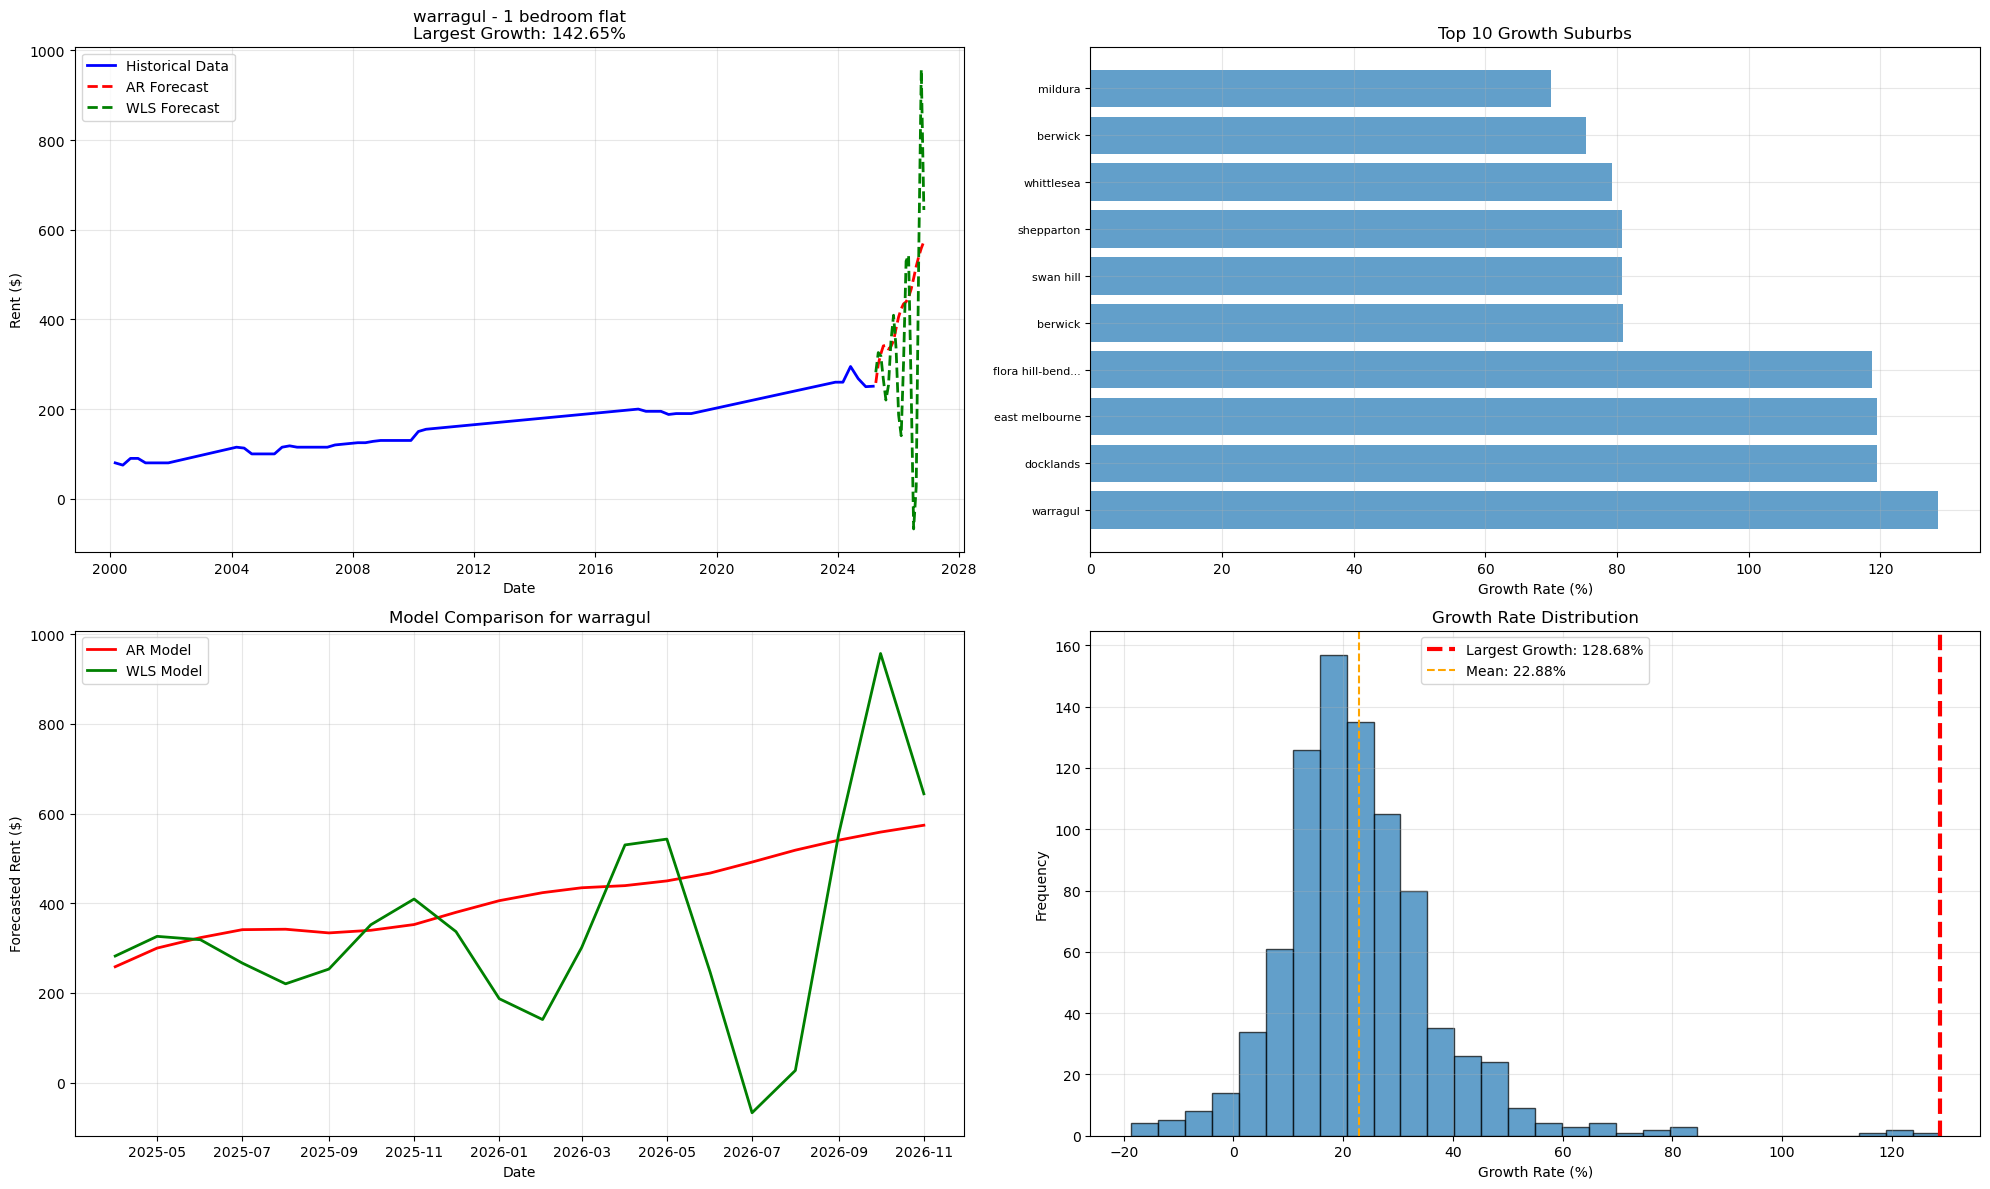

In [18]:
# Detailed analysis of the largest growth suburb
def plot_largest_growth_suburb(results_df, df_original):
    """Plot detailed analysis for the suburb with largest growth"""
    
    largest_growth = results_df.loc[results_df['ar_growth_rate'].idxmax()]
    suburb = largest_growth['suburb']
    property_type = largest_growth['property_type']
    
    # Get historical data
    historical_data = df_original[(df_original["property_type"] == property_type) & 
                                 (df_original["suburb"] == suburb)].reset_index(drop=True)
    
    # Create forecast dates
    last_date = pd.to_datetime(historical_data['date'].iloc[-1])
    future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), 
                                periods=20, freq='MS')
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    
    # 1. Historical data with forecasts
    axes[0, 0].plot(pd.to_datetime(historical_data['date']), historical_data['median_rent'], 
                    'b-', linewidth=2, label='Historical Data')
    axes[0, 0].plot(future_dates, largest_growth['ar_forecast_series'], 
                    'r--', linewidth=2, label='AR Forecast')
    axes[0, 0].plot(future_dates, largest_growth['wls_forecast_series'], 
                    'g--', linewidth=2, label='WLS Forecast')
    axes[0, 0].set_title(f'{suburb} - {property_type}\nLargest Growth: {largest_growth["avg_growth_rate"]:.2f}%')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Rent ($)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Growth rate comparison
    growth_comparison = results_df.nlargest(10, 'ar_growth_rate')
    y_pos = np.arange(len(growth_comparison))
    axes[0, 1].barh(y_pos, growth_comparison['ar_growth_rate'], alpha=0.7)
    axes[0, 1].set_yticks(y_pos)
    axes[0, 1].set_yticklabels([f"{row['suburb'][:15]}..." if len(row['suburb']) > 15 
                               else row['suburb'] for _, row in growth_comparison.iterrows()], fontsize=8)
    axes[0, 1].set_xlabel('Growth Rate (%)')
    axes[0, 1].set_title('Top 10 Growth Suburbs')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Model comparison for largest growth
    model_data = pd.DataFrame({
        'AR': largest_growth['ar_forecast_series'],
        'WLS': largest_growth['wls_forecast_series']
    })
    axes[1, 0].plot(future_dates, model_data['AR'], 'r-', linewidth=2, label='AR Model')
    axes[1, 0].plot(future_dates, model_data['WLS'], 'g-', linewidth=2, label='WLS Model')
    axes[1, 0].set_title(f'Model Comparison for {suburb}')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('Forecasted Rent ($)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Growth rate distribution
    axes[1, 1].hist(results_df['ar_growth_rate'], bins=30, alpha=0.7, edgecolor='black')
    axes[1, 1].axvline(largest_growth['ar_growth_rate'], color='red', linestyle='--', 
                      linewidth=3, label=f'Largest Growth: {largest_growth["ar_growth_rate"]:.2f}%')
    axes[1, 1].axvline(results_df['ar_growth_rate'].mean(), color='orange', linestyle='--', 
                      label=f'Mean: {results_df["ar_growth_rate"].mean():.2f}%')
    axes[1, 1].set_xlabel('Growth Rate (%)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Growth Rate Distribution')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return largest_growth

# Plot detailed analysis
largest_growth_details = plot_largest_growth_suburb(results_df, df1)


In [20]:
# Save results to CSV for further analysis (filtered results without Castlemaine 1 bedroom flat)
results_df.to_csv('../data/analysis/forecast_results_all_suburbs.csv', index=False)
print("Results saved to: ../data/analysis/forecast_results_all_suburbs.csv")
print("Note: Castlemaine 1 bedroom flat has been excluded due to extreme outlier growth rate")

# Summary statistics by property type
print("\n" + "="*60)
print("SUMMARY BY PROPERTY TYPE:")
print("="*60)

property_summary = results_df.groupby('property_type').agg({
    'avg_growth_rate': ['mean', 'std', 'min', 'max', 'count'],
    'current_rent': 'mean',
    'ar_forecast': 'mean',
    'wls_forecast': 'mean'
}).round(2)

print(property_summary)

# Summary statistics by suburb (top 10)
print("\n" + "="*60)
print("TOP 10 SUBURBS BY AVERAGE GROWTH (across all property types):")
print("="*60)

suburb_summary = results_df.groupby('suburb')['ar_growth_rate'].agg(['mean', 'std', 'count']).reset_index()
suburb_summary = suburb_summary.sort_values('mean', ascending=False).head(10)
print(suburb_summary)


Results saved to: ../data/analysis/forecast_results_all_suburbs.csv
Note: Castlemaine 1 bedroom flat has been excluded due to extreme outlier growth rate

SUMMARY BY PROPERTY TYPE:
                avg_growth_rate                              current_rent  \
                           mean    std     min     max count         mean   
property_type                                                               
1 bedroom flat            21.51  44.14  -63.84  384.96   140       387.53   
2 bedroom flat            17.30  28.22  -93.08  243.03   142       504.32   
2 bedroom house           24.09  20.86  -17.98  127.76   140       538.06   
3 bedroom flat            21.03  32.43  -82.52  265.92   140       649.91   
3 bedroom house           15.72  15.88  -32.50  123.77   141       650.85   
4 bedroom house           16.88  23.34 -164.67  125.22   141       823.44   

                ar_forecast wls_forecast  
                       mean         mean  
property_type                          